In [14]:
import scipy.stats as ss
from matplotlib import pyplot as plt
plt.style.use('bmh')
from matplotlib.gridspec import GridSpec as gs
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression, RidgeCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
import pickle

#### Gathering basic info about subject structure

In [2]:
test_type = tuple(input("Enter the types of tests (seperated by a space): ").split()) # type of evaluations
test_amount = tuple(int(input(f"How many tests for {x}?: ")) for x in test_type) # amount of tests per evaluation
max_mark = tuple(int(input(f"{x} out of how many marks?: ")) for x in test_type) # maximum marks for each type of tests

while True:
    weightage = tuple(float(input(f"What is the weightage for {x}?: "))/100 for x in test_type)
    if np.sum(weightage) == 1.0:
        break
    else:
        print("Make sure the weightage for all tests add up to 1.0!\n")
pass_percent = float(input("What is the passing percentage threshold?: "))/100

while True:
    final_test_name = input(f"Which of these tests {test_type} is the final test?: ")
    if final_test_name in test_type:
        break
    else:
        print("Make sure the name of the final test is enterred correctly!\n")

Enter the types of tests (seperated by a space): Lab Assignment Quiz Mid_Term Final
How many tests for Lab?: 8
How many tests for Assignment?: 1
How many tests for Quiz?: 2
How many tests for Mid_Term?: 1
How many tests for Final?: 1
Lab out of how many marks?: 10
Assignment out of how many marks?: 20
Quiz out of how many marks?: 20
Mid_Term out of how many marks?: 50
Final out of how many marks?: 100
What is the weightage for Lab?: 30
What is the weightage for Assignment?: 10
What is the weightage for Quiz?: 10
What is the weightage for Mid_Term?: 20
What is the weightage for Final?: 30
What is the passing percentage threshold?: 60
Which of these tests ('Lab', 'Assignment', 'Quiz', 'Mid_Term', 'Final') is the final test?: Final


In [3]:
tests = pd.DataFrame(index=test_type)
tests['how many'] = test_amount
tests['max marks'] = max_mark
tests['weightage'] = weightage
tests.index.name = 'test type'
tests

,how many,max marks,weightage
test type,,,
Lab,8,10,0.3
Assignment,1,20,0.1
Quiz,2,20,0.1
Mid_Term,1,50,0.2
Final,1,100,0.3


In [31]:
def grades(test_type, test_amount, max_mark, weightage, pass_percent, final_test_name, n=2000, graphs=True): # grades generator
    """Func that generates train/test data for the classifier/regressor and returns the trained classifer/regressor"""
    df = pd.DataFrame(index=range(1, n+1)) # making the dataframe and generating dummy marks
    df.index.name = 'Student'
    for x in range(len(test_type)):
        m = max_mark[x] # storing max marks for each type of test 
        if test_amount[x] > 1:
            for y in range(1, test_amount[x] + 1):
                df[f"{test_type[x]} {y}"] = [round(x) for x in (ss.truncnorm.rvs(((0 - int(m * 0.65)) / (m//3)),
                                         ((m - int(m * 0.65)) / (m//3)), 
                                         loc=round(m * 0.65, 0), scale=(m//3), size=n))]
        else:
            for y in range(1, test_amount[x] + 1):
                df[f"{test_type[x]}"] = [round(x) for x in (ss.truncnorm.rvs(((0 - int(m * 0.65)) / (m//3)),
                                         ((m - int(m * 0.65)) / (m//3)), 
                                         loc=round(m * 0.65, 0), scale=(m//3), size=n))]  

    # calculating total grade weight weightage
    df['Total %'] = [0] * len(df)
    for x in range(len(test_type)):
        df['Total %'] += round((df.filter(regex=test_type[x]).sum(axis=1) / (test_amount[x] * max_mark[x])) * weightage[x], 2)

    # determining pass/fail
    df['Pass/Fail'] = ["Pass" if x >= pass_percent else "Fail" for x in df['Total %']]
    
    print(f"\nStudents passed -> {len(df[df['Pass/Fail'] == 'Pass'])}\
    \nStudents Failed -> {len(df[df['Pass/Fail'] == 'Fail'])}\n")
    
    X = df.drop(['Pass/Fail', 'Total %', 'Final'], axis=1)
    y = df[['Pass/Fail', 'Total %']].copy()
    y['Pass/Fail'] = LabelEncoder().fit_transform(y['Pass/Fail'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y['Pass/Fail'])
    
    passfail = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs=np.arange(0.1, 0.6, 0.1),
                                                                    cv=RepeatedStratifiedKFold(n_splits=10, random_state=7),
                                                                   max_iter=1000, n_jobs=-1, refit=True, 
                                                                    random_state=7,
                                                                   class_weight='balanced')).fit(X_test, 
                                                                                                 y_test['Pass/Fail'])
    gnb = make_pipeline(StandardScaler(), GaussianNB()).fit(X_test, y_test['Pass/Fail'])
    
    if graphs == True:
        for x in range(len(test_type)):
            if test_amount[x] > 1: # plotting grade distribution for tests with more than one evaluation of that type
                if test_amount[x] % 2 != 0:
                    y = test_amount[x]+1
                else:
                    y= test_amount[x]

                fig = plt.figure(figsize=(10, 7), constrained_layout=True)
                grid = gs(nrows=int(y/2), ncols=2, figure=fig)
                for y in range(test_amount[x]):
                    ax = fig.add_subplot(grid[y])
                    sns.distplot(df.filter(regex=test_type[x]).iloc[:, y], fit=ss.norm, ax=ax, norm_hist=True, color='red',
                                hist_kws=dict(edgecolor='black', align='right', color='red'), 
                                 bins=max_mark[x]//2)
                    plt.xticks(size=10)
                    plt.yticks(size=12)
                    plt.xlabel('Marks', fontdict={'size':13})
                    plt.ylabel('Density', fontdict={'size':13})
                    plt.title(f"{test_type[x]} {y+1}", fontsize=14)
                    plt.tight_layout()
                fig.suptitle(f"Grade for {test_type[x]}", fontsize=15)
                grid.tight_layout(fig)
                if graphs == True:
                    plt.show()
            else: # plotting grade distribution for singular evaluation test 
                plt.figure(figsize=(8, 5))
                sns.distplot(df[test_type[x]], fit=ss.norm, norm_hist=True, color='red',
                                hist_kws=dict(edgecolor='black', align='right', color='red'), 
                             bins=max_mark[x]//2)
                plt.title(f"Grade for {test_type[x]}", fontsize=14)
                plt.xlabel('Marks', fontdict={'size':13})
                plt.xticks(size=12)
                plt.yticks(size=12)
                plt.ylabel('Density', fontdict={'size':13})
                plt.tight_layout()
                plt.show()
            
        fig, ax = plt.subplots()
        plot_confusion_matrix(passfail, X_test, y_test['Pass/Fail'], labels=[0, 1], 
                              display_labels=['Fail', 'Pass'], cmap='afmhot', ax=ax)
        plt.rcParams.update({'font.size':18})
        ax.set_title('Confusion Matrix')
        plt.show()
    
    overallgrade = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1)).fit(X_test, y_test['Total %'])
    ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=np.arange(0.1, 1.1, 0.1),
                                                   cv=RepeatedKFold(n_splits=10))).fit(X_test, y_test['Total %'])
    
    print("LogisticRegressionCV classifer:-")
    print(f"Accuracy -> {round(passfail.score(X_test, y_test['Pass/Fail'])*100, 2)}%")
    print(f"f1_score -> {round(f1_score(y_test['Pass/Fail'], passfail.predict(X_test))*100, 2)}%\n")
    
    print("GaussianNB Classifier:-")
    print(f"Accuracy -> {round(gnb.score(X_test, y_test['Pass/Fail'])*100, 2)}%")
    print(f"f1_score -> {round(f1_score(y_test['Pass/Fail'], gnb.predict(X_test))*100, 2)}%\n")
    
    print("LinearRegression regressor:-")
    print(f"Accuracy -> {round(overallgrade.score(X_test, y_test['Total %'])*100, 2)}%\n")
    
    print("RidgeCV regressor:-")
    print(f"Accuracy -> {round(ridge.score(X_test, y_test['Total %'])*100, 2)}%")
    return passfail, overallgrade


Students passed -> 869    
Students Failed -> 1131



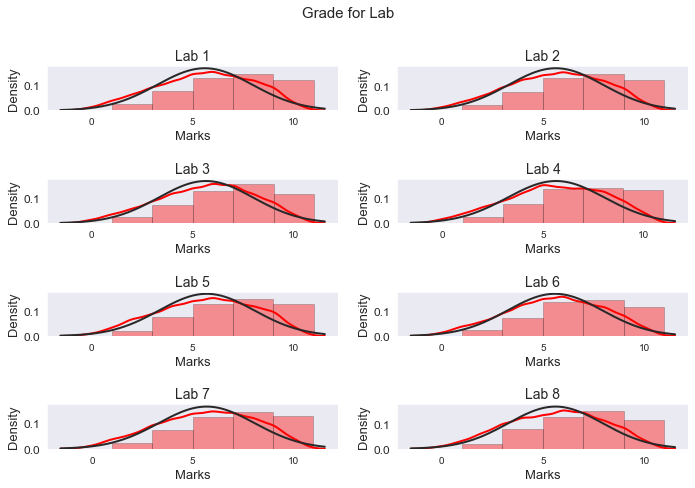

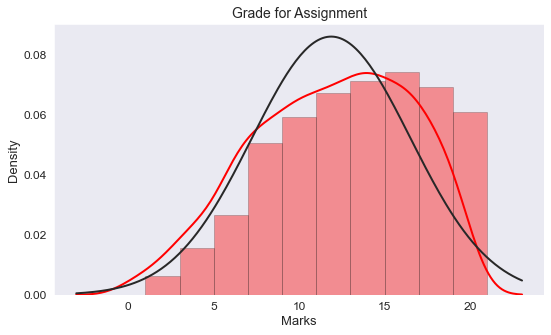

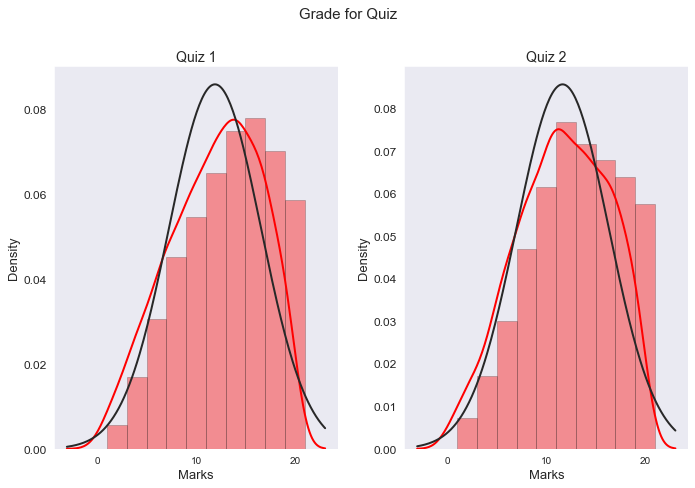

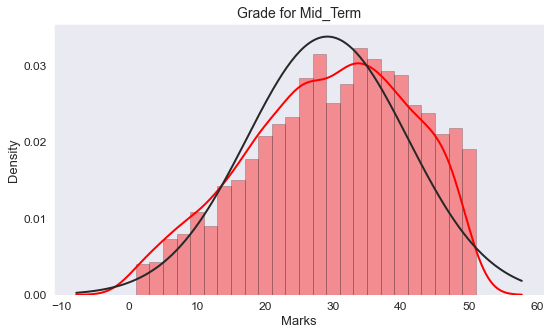

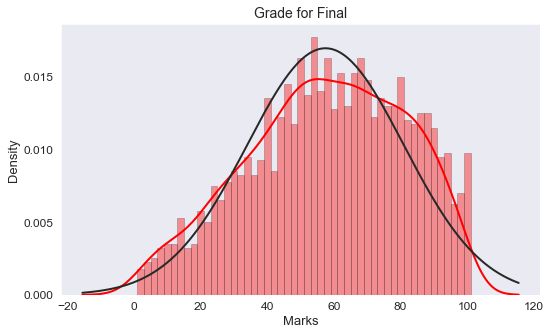

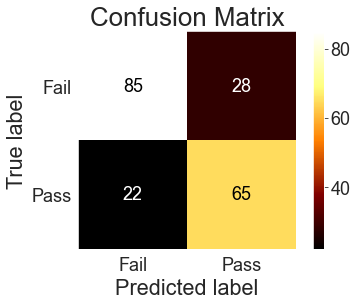

LogisticRegressionCV classifer:-
Accuracy -> 75.0%
f1_score -> 72.22%

GaussianNB Classifier:-
Accuracy -> 74.0%
f1_score -> 69.77%

LinearRegression regressor:-
Accuracy -> 41.62%

RidgeCV regressor:-
Accuracy -> 41.62%


In [40]:
passfail, overallgrade = grades(test_type, test_amount, max_mark, weightage, pass_percent, final_test_name)

In [6]:
# saving models
with open('passfail', 'wb') as f:
    pickle.dump(passfail, f)
    
with open('overallgrade', 'wb') as f:
    pickle.dump(overallgrade, f)

In [7]:
passfail = pickle.load(open('passfail', 'rb'))
overallgrade = pickle.load(open('overallgrade', 'rb'))

In [9]:
lab_1 = 8
lab_2 = 9
lab_3 = 10
lab_4 = 8
lab_5 = 9
lab_6 = 8
lab_7 = 9
lab_8 = 7

assign_1 = 17
assign_2 = 18
assign_3 = 15
assign_4 = 19

mid_term = 39

project = 74

test = np.array([lab_1, lab_2, lab_3, lab_4, lab_5, lab_6, lab_7, lab_8,
       assign_1, assign_2, assign_3, assign_4,
       mid_term,
       project]).reshape(1, -1)

In [10]:
overallgrade.predict(test)

array([0.73721178])